In [3]:
from src.data_handler import CoinDataStore
from src.simple_wash_detector_utils import detect_wash_trades_nearest

In [4]:
store = CoinDataStore("HYPE", engine="fastparquet")
time_diff_s = 10 * 60 # 10 minutes difference
price_diff_pct = 0.01
size_diff_pct = 0.01

df_detected = detect_wash_trades_nearest(store, time_diff_s, price_diff_pct, size_diff_pct)
df_detected

,wallet_id,day,open_time,close_time,duration_s,open_side,close_side,open_price,close_price,price_change_pct,open_size,close_size,size_change_pct,pairing_direction,pair_id
0,2,2025-03-22,2025-03-22 10:50:41.250,2025-03-22 10:51:26.900,45.65,sell,buy,16.397001,16.414000,0.001037,8.40,8.41,0.001191,sell_to_buy,0
1,2,2025-03-22,2025-03-22 10:51:59.150,2025-03-22 10:54:38.300,159.15,sell,buy,16.410000,16.396000,0.000853,12.19,12.20,0.000820,sell_to_buy,1
2,2,2025-03-22,2025-03-22 10:56:26.650,2025-03-22 10:56:48.300,21.65,sell,buy,16.184000,16.174000,0.000618,12.36,12.45,0.007282,sell_to_buy,2
3,2,2025-03-22,2025-03-22 10:56:48.300,2025-03-22 10:56:53.150,4.85,buy,sell,16.174000,16.174999,0.000062,12.45,12.37,0.006426,buy_to_sell,3
4,2,2025-03-22,2025-03-22 10:56:53.150,2025-03-22 10:59:05.400,132.25,sell,buy,16.174999,16.198999,0.001484,12.37,12.34,0.002425,sell_to_buy,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24153,18791,2025-06-17,2025-06-17 00:51:59.800,2025-06-17 00:52:03.150,3.35,buy,sell,42.644001,42.591999,0.001219,0.26,0.26,0.000000,buy_to_sell,24153
24154,18791,2025-06-17,2025-06-17 00:52:03.150,2025-06-17 00:52:05.150,2.00,sell,buy,42.591999,42.582001,0.000235,0.26,0.26,0.000000,sell_to_buy,24154
24155,18791,2025-06-17,2025-06-17 00:52:05.150,2025-06-17 00:52:11.350,6.20,buy,sell,42.582001,42.507999,0.001738,0.26,0.26,0.000000,buy_to_sell,24155
24156,18791,2025-06-17,2025-06-17 00:52:11.350,2025-06-17 00:52:13.600,2.25,sell,buy,42.507999,42.504002,0.000094,0.26,0.26,0.000000,sell_to_buy,24156


In [5]:
df_detected["open_size"].sum() / 10**6

np.float32(0.6237666)

In [6]:
store = CoinDataStore("HYPE", engine="fastparquet")
df_all = store.load_all()
df_all

,price,size,time,seller,buyer
0,16.392000,30.090000,2025-03-22 10:50:22.123535751,3,33
1,16.392000,101.910004,2025-03-22 10:50:22.123535751,8,33
2,16.392000,3.000000,2025-03-22 10:50:22.123535751,75,33
3,16.393000,116.820000,2025-03-22 10:50:23.330157586,19,33
4,16.393000,102.989998,2025-03-22 10:50:23.531265928,8,33
...,...,...,...,...,...
339563,40.618000,10.260000,2025-06-17 19:59:58.719000000,15399,198
339565,40.613998,4.620000,2025-06-17 19:59:58.719000000,15399,133
339569,40.610001,7.390000,2025-06-17 19:59:58.719000000,15399,424
339570,40.610001,22.830000,2025-06-17 19:59:58.781000000,15399,198


In [7]:
df_all["size"].sum() / 10**6

np.float32(9.648145)

In [8]:
100/3085

0.03241491085899514

In [14]:
import pandas as pd
import numpy as np


def detected_to_dfwash_full(df_detected: pd.DataFrame) -> pd.DataFrame:
    # core dfwash schema
    mapped = pd.DataFrame({
        "wallet_id": df_detected["wallet_id"],
        "price1": df_detected["open_price"],
        "size1": df_detected["open_size"],
        "price2": df_detected["close_price"],
        "size2": df_detected["close_size"],
        "side1": df_detected["open_side"],
        "side2": df_detected["close_side"],
        "t1": pd.to_datetime(df_detected["open_time"], errors="coerce"),
        "t2": pd.to_datetime(df_detected["close_time"], errors="coerce"),
        "delta_seconds": df_detected["duration_s"],
    }, index=df_detected.index)

    # size ratio
    mapped["size_ratio"] = mapped["size2"] / mapped["size1"].replace(0, np.nan)

    # enforce lightweight dtypes
    cast = {
        "wallet_id": "uint32",
        "price1": "float32", "size1": "float32",
        "price2": "float32", "size2": "float32",
        "delta_seconds": "float32", "size_ratio": "float32",
    }
    for c, dt in cast.items():
        if c in mapped.columns:
            try:
                mapped[c] = mapped[c].astype(dt, copy=False)
            except Exception:
                pass

    # derived cols
    mapped["direction"] = (mapped["side1"].astype("string") + "->" + mapped["side2"].astype("string")).astype("category")
    mapped["dt_s"] = mapped["delta_seconds"].astype("float32")
    mapped["size_err_pct"] = (mapped["size_ratio"] - 1.0).abs().astype("float32") * 100.0
    base = mapped["price1"].replace(0, np.nan)
    mapped["price_change_pct"] = ((mapped["price2"] - mapped["price1"]) / base).astype("float32")
    mapped["abs_price_change_bps"] = (mapped["price_change_pct"].abs() * 1e4).astype("float32")
    mapped["same_price"] = (mapped["price2"] - mapped["price1"]).abs() <= 1e-8
    mapped["date"] = mapped["t1"].dt.date
    mapped["hour"] = mapped["t1"].dt.hour.astype("int16")
    mapped["dow"] = mapped["t1"].dt.dayofweek.astype("int8")

    # combine original df_detected + mapped features
    df_full = pd.concat([df_detected.reset_index(drop=True), mapped.reset_index(drop=True)], axis=1)
    # remove duplicated column names across the whole frame
    df_full = df_full.loc[:, ~df_full.columns.duplicated()]

    return df_full


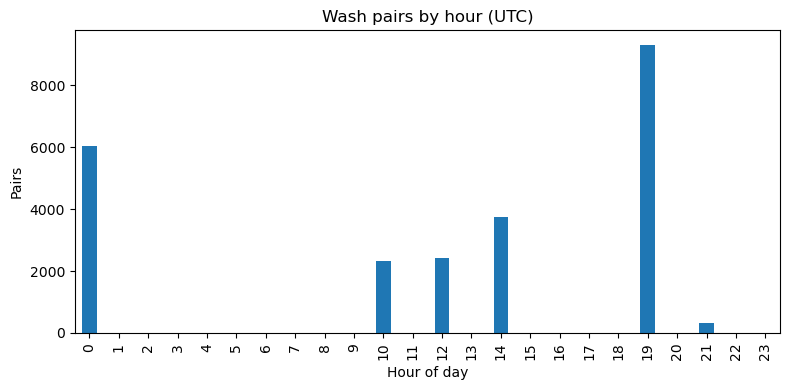

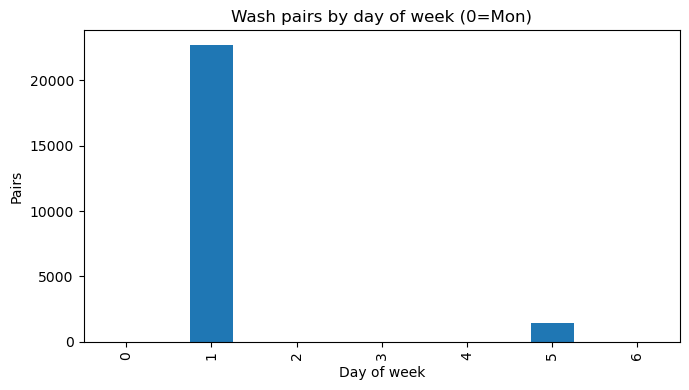

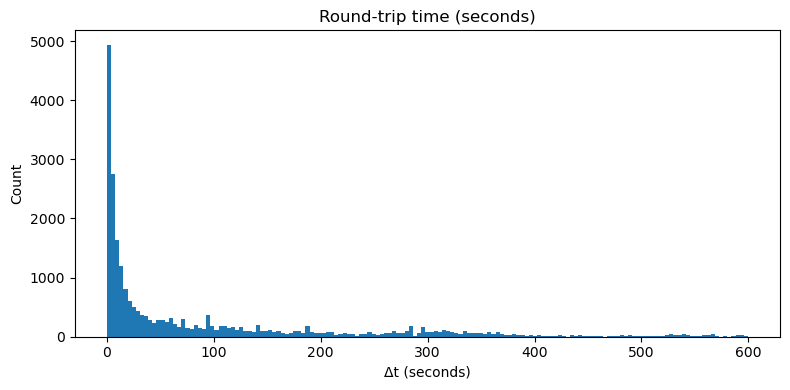

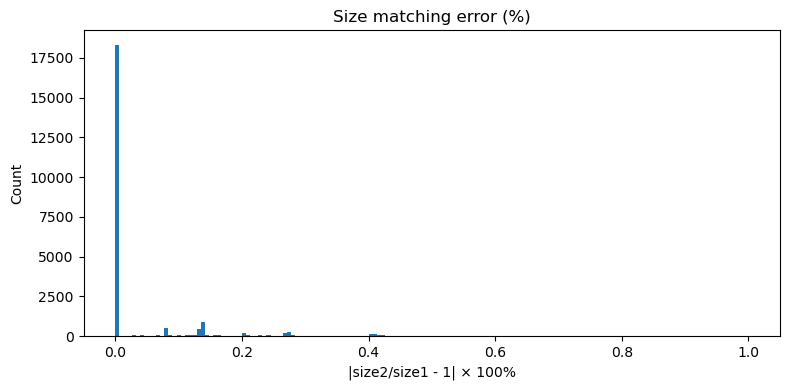

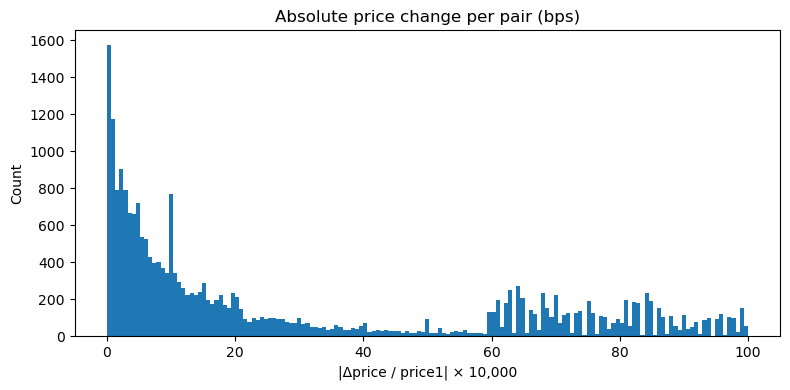

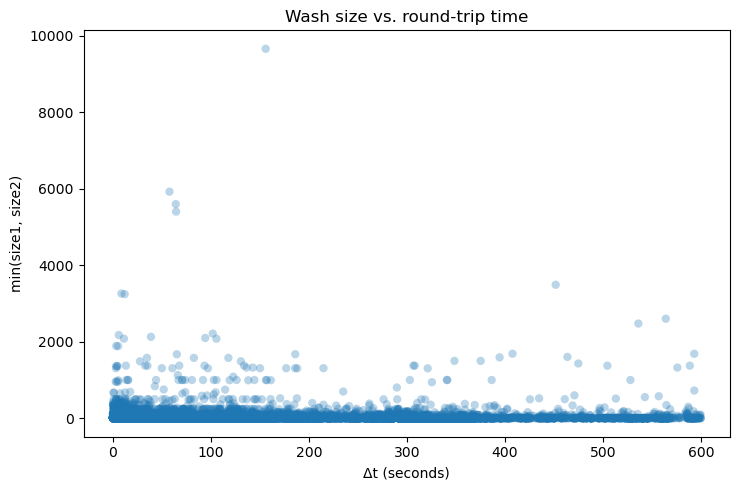

/home/asevlad/program_files/github_asevlad/Hyperliquid_Wash_Trading_detection/src/wash_trading_pairs_analyser.py:134: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H").sum().fillna(0).cumsum())


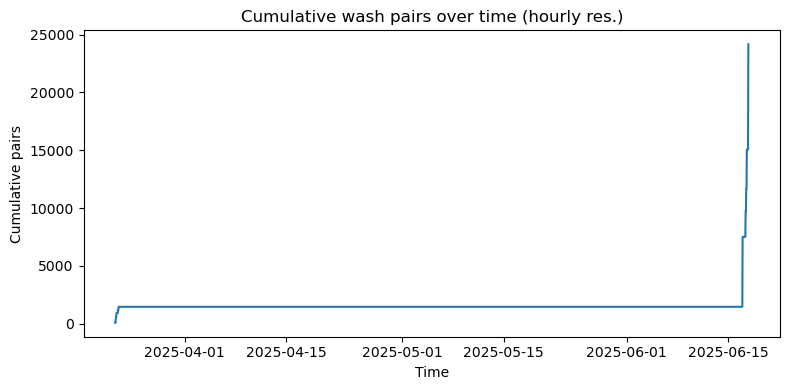

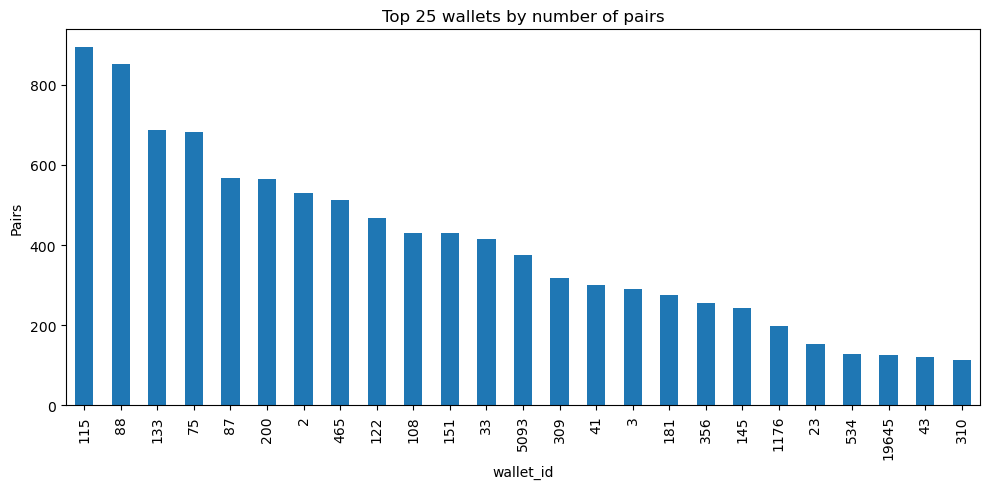

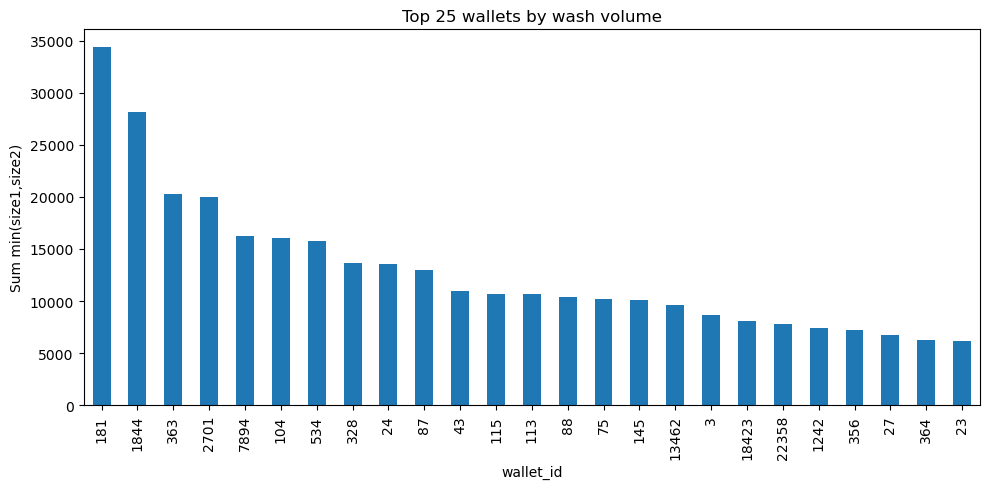

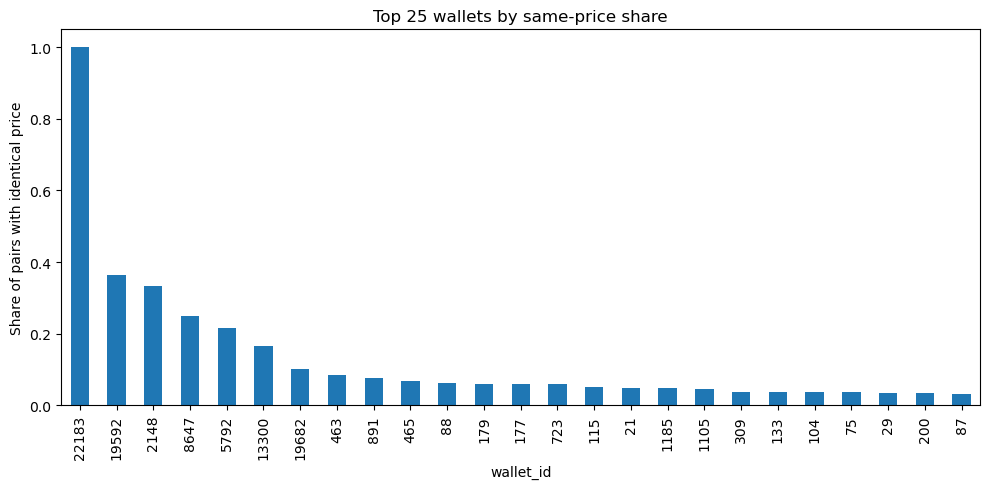

Saved plots to: /home/asevlad/program_files/github_asevlad/Hyperliquid_Wash_Trading_detection/analysis/HYPE/plots_dfwash_general


In [15]:
from src.wash_trading_pairs_analyser import make_dfwash_plots, global_snapshot, per_wallet_leaderboard, \
    plot_wash_notional_by_date_bar, plot_wash_volume_by_date_bar

# If you have the DataFrame already:
token = "HYPE"

def wash_trading_pairs_analysis(dfwash: pd.DataFrame, token: str, detector_type: str):
    dfwash = detected_to_dfwash_full(df_detected)

    make_dfwash_plots(dfwash, out_dir=f"analysis/{token}/{detector_type}/plots_dfwash_general", show=True, top_wallets=25)
    global_snapshot(dfwash, out_dir=f"analysis/{token}/{detector_type}/", fname=f"global_snapshot_{token}.json")

    per_wallet_leaderboard(dfwash, top=50, out_dir=f"analysis/{token}/{detector_type}/")
    plot_wash_volume_by_date_bar(dfwash, freq="D", out_dir=f"analysis/{token}/{detector_type}/", show=False)
    plot_wash_notional_by_date_bar(dfwash, freq="D", out_dir=f"analysis/{token}/{detector_type}/", show=False)